# Machine Learning From Scratch
This notebook implements the k-means algorithm for image compression using Python and NumPy. 

This project is part of my exploration of machine learning fundamentals.

### K-Means: Image Compression

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

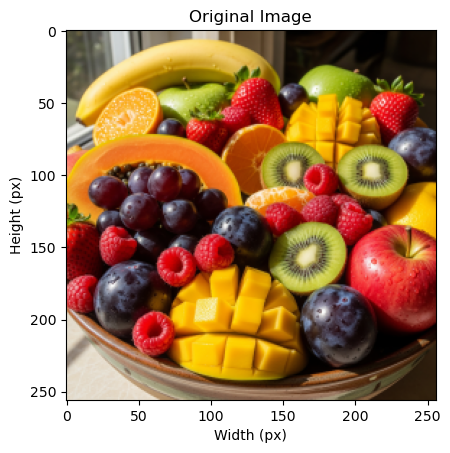

In [2]:
# This is the image that will be compressed using k-means. Image generated by Google Gemini.
fruit_path = "fruit.png" # Use your path for fruit.png
plt.imshow(plt.imread(fruit_path))
plt.title("Original Image")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.show()

In [3]:
# Image to NumPy array
og_image = Image.open(fruit_path)
img_array = np.array(og_image, dtype = np.float64)

In [4]:
# Image Array Dimensions - 256 x 256 pixels, RGBA --> 256 x 256 pixels, RGB
print(f"Original Shape: {img_array.shape}")
img_array = img_array[:, :, :3]
print(f"New Shape: {img_array.shape}")

Original Shape: (256, 256, 4)
New Shape: (256, 256, 3)


In [5]:
# (256, 256, 3) --> (65536, 3)
img_array = np.reshape(img_array, (img_array.shape[0] * img_array.shape[1], 3))
img_array.shape

(65536, 3)

In [12]:
# Modified version of the original k-means function
def kmeans_img(X,k,num_iters=10,num_inits=10):
    """
    REQUIRES NUMPY AS NP
    
    Executes the k-means algorithm
    
    Args:
        X - Dataset (2D NumPy array)
        k - Number of desired clusters
        num_iters - Number of desired iterations; default is 20
        num_initializations - Number of desired cluster initializations; default is 5

    Returns:
        centroid_array - 2D NumPy array of centroids
    """
    if type(k) != int or k <= 0:
        raise ValueError("Number of clusters must be a positive integer.")
    if (not isinstance(X, np.ndarray)) or len(X.shape) != 2:
        raise ValueError("The dataset must be a 2D NumPy array.")
    if X.size == 0:
        raise ValueError("The dataset must not be empty!")

    inertia_tracker = []
    
    INERTIA_IDX = 0
    CENTROID_ARRAY_IDX = 1
    
    for init_num in range(num_inits):
        print(f"K-Means: Iteration {init_num} of {num_inits}")
        centroid_array = np.zeros((k, X.shape[1]))
        
        random_indices = np.random.choice(X.shape[0], size = k, replace = False)
        centroid_array = X[random_indices]

        for iter_num in range(num_iters):
            distance_array = np.zeros((X.shape[0], k))
            inertia = 0

            differences = X[:, np.newaxis, :] - centroid_array[np.newaxis, :, :]
            distances = np.linalg.norm(differences, axis = 2)
            closest_centroids = np.argmin(distances, axis = 1)

            cluster_dict = {idx:X[closest_centroids == idx] for idx in range(k)}
    
            for centroid_idx in range(k):
                cluster_array = cluster_dict[centroid_idx]
    
                if cluster_array.shape[0] == 0:
                    rand_row_idx = np.random.randint(low = 0, high = X.shape[0])
                    new_centroid = X[rand_row_idx]
                else:
                    new_centroid = cluster_array.mean(axis = 0)
                
                centroid_array[centroid_idx] = new_centroid
              
        for centroid_idx in range(k):
            curr_centroid = centroid_array[centroid_idx]
            curr_points = cluster_dict[centroid_idx]
            inertia += np.sum((curr_points - curr_centroid) ** 2)
    
        inertia_tracker.append((inertia, centroid_array.copy()))

    inertia_tracker.sort(key = lambda x : x[INERTIA_IDX])

    centroid_array = inertia_tracker[0][CENTROID_ARRAY_IDX]

    print("K-Means: FINISHED")

    return centroid_array

In [13]:
# Obtain the 16 most "common" colors for compression via k-means
k = 16
comp_centroid_array = kmeans_img(img_array,k)

K-Means: Iteration 0 of 10
K-Means: Iteration 1 of 10
K-Means: Iteration 2 of 10
K-Means: Iteration 3 of 10
K-Means: Iteration 4 of 10
K-Means: Iteration 5 of 10
K-Means: Iteration 6 of 10
K-Means: Iteration 7 of 10
K-Means: Iteration 8 of 10
K-Means: Iteration 9 of 10
K-Means: FINISHED


In [14]:
# To preserve the color-position relationship, the centroid indices for all pixels must be determined sequentially
def closest_centroid_sequential(X,centroid_array):
    """
    REQUIRES NUMPY AS NP

    Finds the closest centroid(s) for
    given data points.

    Args:
        X - Dataset (2D NumPy array)
        centroid_array - 2D NumPy array of centroids

    Returns:
        centroid_idx - 1D NumPy array of centroid indices
    """
    if (not isinstance(X, np.ndarray)) or len(X.shape) != 2:
        raise ValueError("The dataset must be a 2D NumPy array.")
    if X.size == 0:
        raise ValueError("The dataset must not be empty!")
    if (not isinstance(centroid_array, np.ndarray)) or len(centroid_array.shape) != 2:
        raise ValueError("The centroid array must be a 2D NumPy array.")
    if centroid_array.size == 0:
        raise ValueError("The centroid array must not be empty!")

    differences = X[:, np.newaxis, :] - centroid_array[np.newaxis, :, :]
    distances = np.linalg.norm(differences, axis = 2)
    centroid_idx = np.argmin(distances, axis = 1).astype(np.uint8)

    return centroid_idx

In [15]:
# Retrieving and mapping compressed colors
centroid_idx = closest_centroid_sequential(img_array,comp_centroid_array)
new_img_array = comp_centroid_array[centroid_idx, :]
new_img_array = np.reshape(new_img_array, (256, 256, 3))

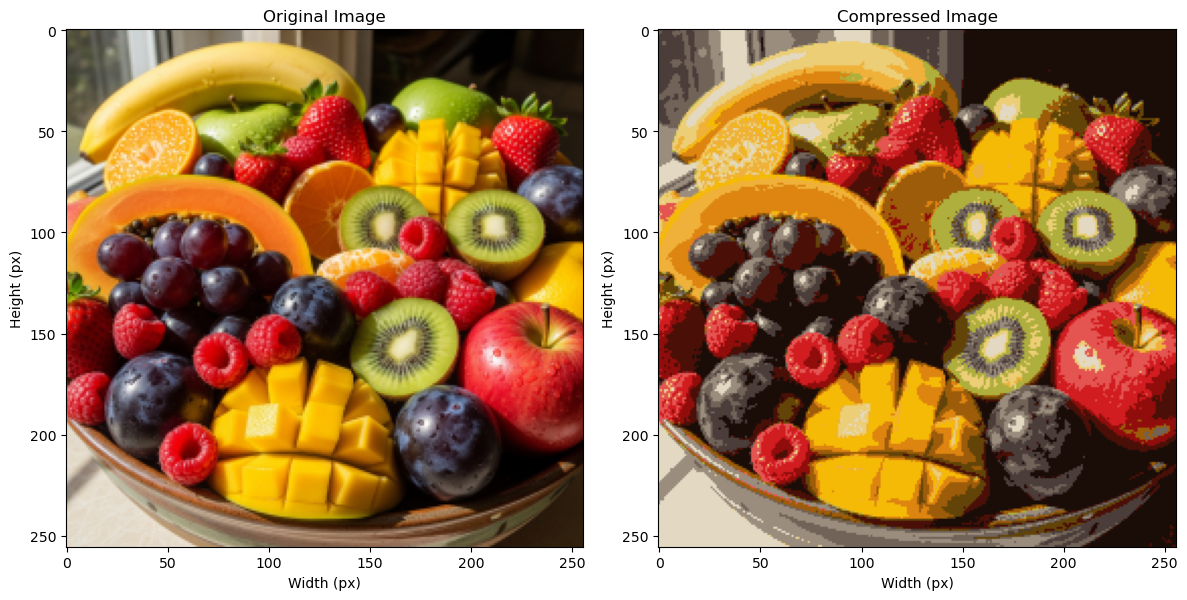

In [16]:
# Side-by-side comparison of original image vs compressed image
fruit_path = "fruit.png" # Use your path for fruit.png
fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].imshow(plt.imread(fruit_path))
axes[0].set_title("Original Image")
axes[0].set_xlabel("Width (px)")
axes[0].set_ylabel("Height (px)")

new_img_array = (new_img_array / 255).astype(np.float32) # Conversion from PIL uint8 to pyplot 32-bit float
plt.imsave(new_fruit_path := "compressed_fruit.png", new_img_array)
axes[1].imshow(plt.imread(new_fruit_path))
axes[1].set_title("Compressed Image")
axes[1].set_xlabel("Width (px)")
axes[1].set_ylabel("Height (px)")

plt.tight_layout()
plt.show()

**Original image size**: 256 x 256 x 3 x 8  = **~1,572,864 bits**

**Compressed image size**: 256 x 256 x 4 + 16 x 3 x 8 = **~262,528 bits**

((1,572,864 - 262,528) / 1,572,864) * 100 = **~83.3% decrease in image size**